# Loading the Data

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
                               ])

In [3]:
training_dataset = datasets.ImageFolder(root='data/train', transform=transform)

In [4]:
training_dataset.classes

['Accident', 'Non Accident']

In [5]:
validation_dataset = datasets.ImageFolder(root='data/val', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

In [6]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
batch = next(iter(train_loader))
images,labels = batch
print(images.shape, labels.shape)

torch.Size([64, 3, 64, 64]) torch.Size([64])


# Visualizing Images

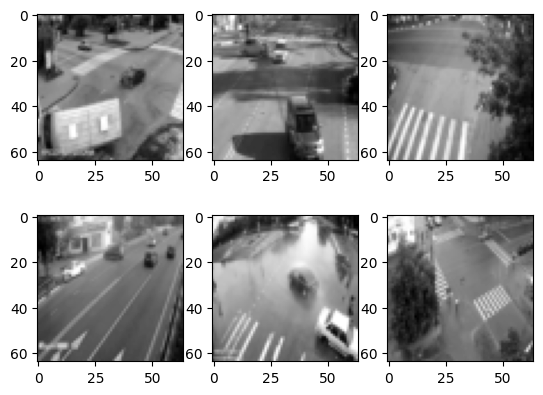

In [46]:
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i][0], cmap = 'gray')
plt.show()

# Convolutional Neural Network

In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 32 x 16 x 16
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 8 x 8
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 4 x 4
            nn.Flatten(),
            nn.Linear(128*4*4, 1024),  # Updated linear layer input size
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, X):
        return self.network(X)


# Training

In [53]:
model = CNNModel()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
num_epochs = 20

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

for epoch in range(num_epochs):
    for batch in train_loader:
        #forward pass
        inputs, labels = batch
        outputs = model(inputs)
        l = loss(outputs, labels)
        #backward pass
        l.backward()
        #weight update
        optimizer.step()
        optimizer.zero_grad()
    
    batch_acc = []
    for batch in val_loader:
        inputs, labels = batch
        outputs = model(inputs)
        acc = accuracy(outputs, labels)
        batch_acc.append(acc)
    epoch_acc = torch.stack(batch_acc).mean()
    print(f"Epoch [{epoch}], Model Accuracy: {epoch_acc.item():.4f}")

Epoch [0], Model Accuracy: 0.6406
Epoch [1], Model Accuracy: 0.6392
Epoch [2], Model Accuracy: 0.5731
Epoch [3], Model Accuracy: 0.6025
Epoch [4], Model Accuracy: 0.7583
Epoch [5], Model Accuracy: 0.8249
Epoch [6], Model Accuracy: 0.8318
Epoch [7], Model Accuracy: 0.8346
Epoch [8], Model Accuracy: 0.8952
Epoch [9], Model Accuracy: 0.8571
Epoch [10], Model Accuracy: 0.8943
Epoch [11], Model Accuracy: 0.8934
Epoch [12], Model Accuracy: 0.8814
Epoch [13], Model Accuracy: 0.9040
Epoch [14], Model Accuracy: 0.9177
Epoch [15], Model Accuracy: 0.9099
Epoch [16], Model Accuracy: 0.8961
Epoch [17], Model Accuracy: 0.8874
Epoch [18], Model Accuracy: 0.8511
Epoch [19], Model Accuracy: 0.8952


In [55]:
import time

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Send the model to the defined device
model.to(device)

# Initialize a list to store accuracies for each batch
batch_acc = []

# Start timing
start_time = time.time()

# Loop over all batches in the test loader
for inputs, labels in test_loader:
    # Send data to the device
    inputs, labels = inputs.to(device), labels.to(device)
    
    # No need to track gradients for inference
    with torch.no_grad():
        outputs = model(inputs)
    
    # Calculate accuracy and store it
    acc = accuracy(outputs, labels)
    batch_acc.append(acc)

# End timing
end_time = time.time()

# Calculate the mean accuracy across all batches
test_accuracy = torch.stack(batch_acc).mean()
print(f"Test accuracy of Model is {test_accuracy:.4f}")

# Calculate the elapsed time for processing
elapsed_time = end_time - start_time

# Calculate the total number of images processed
total_images = len(test_loader.dataset)

# Calculate frames per second (FPS)
fps = total_images / elapsed_time
print(f"Processed {total_images} images in {elapsed_time:.3f} seconds, {fps:.2f} FPS")


Test accuracy of Model is 0.9470
Processed 100 images in 1.185 seconds, 84.38 FPS


In [52]:
test_accuracy_float = float(f"{test_accuracy:.4f}")
if test_accuracy_float > 0.9427:
    torch.save(model, 'model.pth')

In [17]:
saved_model = torch.load('0.95.pth')
saved_model.eval()

correct = 0
total = 0
with torch.no_grad():  # Disable gradient tracking
    for inputs, labels in test_loader:
        outputs = saved_model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')

import torch

# Loop through the test dataset
for i, (inputs, labels) in enumerate(test_loader):
    outputs = saved_model(inputs)
    _, predicted = torch.max(outputs, 1)

    for j in range(inputs.size(0)):  # Iterate over each image in the batch
        image = inputs[j]  # Get the image
        true_label = labels[j].item()  # Actual label
        pred_label = predicted[j].item()  # Predicted label

        print(f"Frame {i * test_loader.batch_size + j}: True Label - {true_label}, Predicted Label - {pred_label}")



Accuracy of the model on the test images: 92.0%
Frame 0: True Label - 0, Predicted Label - 0
Frame 1: True Label - 0, Predicted Label - 0
Frame 2: True Label - 0, Predicted Label - 0
Frame 3: True Label - 0, Predicted Label - 0
Frame 4: True Label - 0, Predicted Label - 0
Frame 5: True Label - 0, Predicted Label - 0
Frame 6: True Label - 0, Predicted Label - 0
Frame 7: True Label - 0, Predicted Label - 0
Frame 8: True Label - 0, Predicted Label - 0
Frame 9: True Label - 0, Predicted Label - 0
Frame 10: True Label - 0, Predicted Label - 0
Frame 11: True Label - 0, Predicted Label - 0
Frame 12: True Label - 0, Predicted Label - 0
Frame 13: True Label - 0, Predicted Label - 0
Frame 14: True Label - 0, Predicted Label - 0
Frame 15: True Label - 0, Predicted Label - 0
Frame 16: True Label - 0, Predicted Label - 0
Frame 17: True Label - 0, Predicted Label - 0
Frame 18: True Label - 0, Predicted Label - 0
Frame 19: True Label - 0, Predicted Label - 0
Frame 20: True Label - 0, Predicted Label 